# San Francisco Parking Exploratory Data Analysis
this notebook is for the in depth analyis of the San Francisco Parking Ticket data. The main goal of this will be to answer four questions. 

1. Can we identify streets that are less likely for enforcement officer to travel through, when looking fo residential overtime tickets?

2. How long can we expect to park before we have to move our car?

3. Which hour of street cleaning is most effective at getting people ticketed?

4. Does less frequent street cleaning get mroe tickets per sweep?




In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime as dt
import time
from scipy import stats
#import geopandas as gpd
#import folium
import sqlite3
import seaborn as sns
import statsmodels.formula as sm
%matplotlib inline

In [2]:
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf

In [3]:
project_folder = '/home/colin/Desktop/SF_Parking/'
raw_folder = project_folder + 'data/raw/'
proc_folder = project_folder + 'data/processed/'
image_folder = project_folder + 'reports/figures/analysis/'

In [4]:
conn = sqlite3.connect(proc_folder + 'SF_Parking.db')
c = conn.cursor()
tables = result_query("SELECT name FROM sqlite_master where type = 'table'")
tables

,name
0,raw_ticket_data
1,raw_address_data
2,single_address
3,ticket_data
4,street_sweep_data
5,address_data
6,street_volume_data


# Theory
I have a theory that parking enforcement officers  don't like busy streets when giving out 'Residential Overtime' tickets. It generally takes more time to mark it and then have to come back later, and they would most likely try to avoid them altogether. Let's see if that has any merrit. 

In [5]:
#Lets categorize addresses by our street volume 
streets = result_query("Select distinct t2.lineid, nhood, distance, total_ea, vvol_carea, vvol_busea, vvol_trkea, speed_ea, count(*) total_tickets "
                       'from ticket_data t1 join address_data t2 on t1.address = t2.address ' 
                       ' join street_volume_data t3 on t2.lineid = t3.lineid '
                       " Where ViolationDesc = 'RES/OT' and nhood not in ('Tenderloin', 'Financial District/South Beach') and total_ea > 0 group by t3.lineid")
c.execute('Select Max(TickIssueDate), Min(TickIssueDate) from ticket_data')
totaldays = c.fetchone()
maxdate = time.strptime( totaldays[0], '%Y-%m-%d %H:%M:%S')
mindate = time.strptime( totaldays[1], '%Y-%m-%d %H:%M:%S')
totaldays = (time.mktime(maxdate) - time.mktime(mindate)) / (60*60*24)
totalyears = totaldays /365

In [6]:
#to avoid any problems log transforming, we'll add 1 to all street volume
streets['total_ea'] = streets['total_ea'] + 1

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Total Tickets')

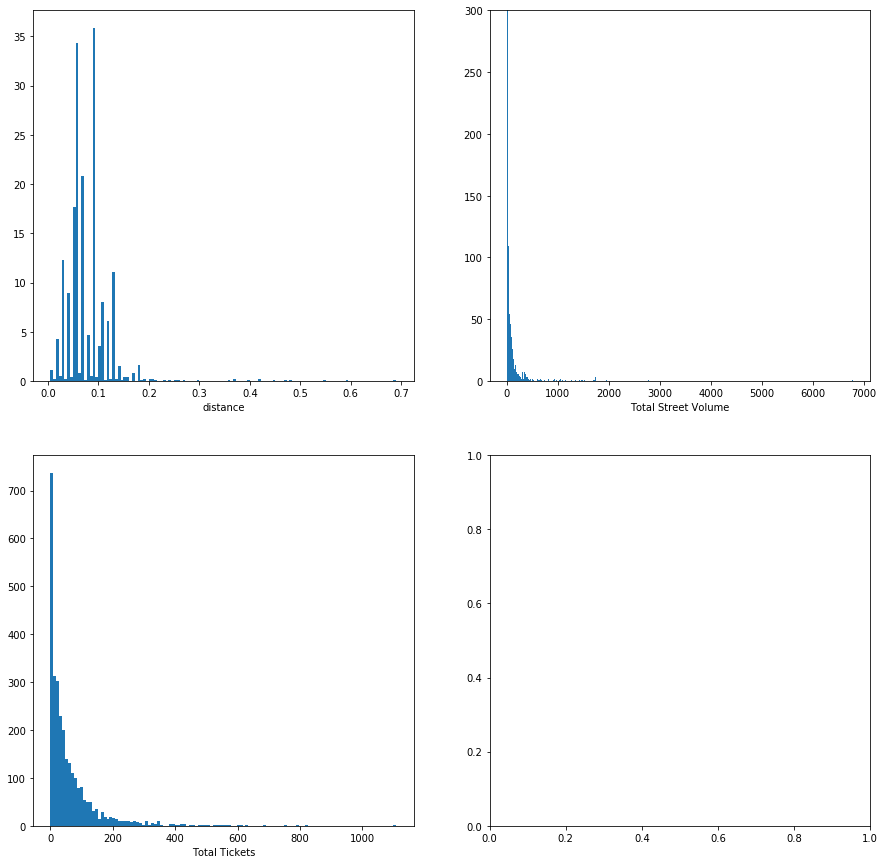

In [7]:
import matplotlib.pyplot as plt 
fig, axplots = plt.subplots(2,2, figsize = (15, 15))

axplots[0,0].hist(streets.distance, bins = 'auto', normed = True)
axplots[0,0].set_xlabel('distance')

axplots[0,1].hist(streets.total_ea, bins = 'auto')
axplots[0,1].set_xlabel('Total Street Volume')
axplots[0,1].set_ylim(0,300)

axplots[1,0].hist(streets.total_tickets, bins = 'auto' )
axplots[1,0].set_xlabel('Total Tickets')

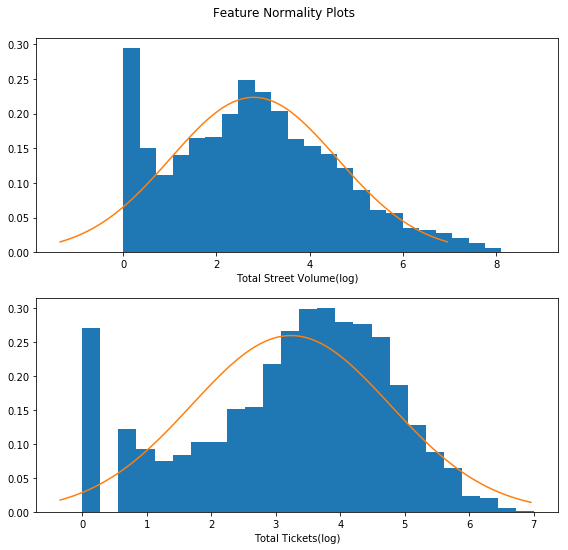

In [8]:
#Lets Log Transform a few 
from scipy.stats import norm

fig, axplots = plt.subplots(2, figsize = (8, 8))
log_volume = np.log(streets['total_ea'])
log_tickets = np.log(streets['total_tickets'])
vol_mean = log_volume.mean()
tick_mean = log_tickets.mean()
vol_std = log_volume.std()
tick_std = log_tickets.std()
vol_normals = norm(loc = vol_mean, scale = vol_std)
vol = np.linspace(vol_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 100)

tick_normals = norm(loc = tick_mean, scale = tick_std)
ticks = np.linspace(tick_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 
                        100)


axplots[0].hist(log_volume, bins = 'auto', density = True)
axplots[0].set_xlabel('Total Street Volume(log)')
axplots[0].plot(vol, vol_normals.pdf(vol))

axplots[1].hist(np.log(streets.total_tickets), bins = 'auto', density = True )
axplots[1].set_xlabel('Total Tickets(log)')
axplots[1].plot(ticks, tick_normals.pdf(ticks))

fig.suptitle('Feature Normality Plots')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [9]:
#'Zero' volume streets make the fit more skewed on the left side
streets.shape

(2909, 9)

Text(0.5, 1.0, 'Cumulative Distribution of Street Volume')

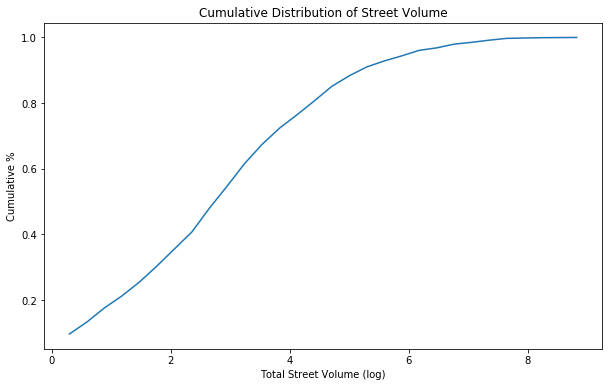

In [10]:
#Lets look at the percentiles of streetvolume
plt.figure(figsize = (10,6))
counts, bin_edges = np.histogram(np.log(streets['total_ea']), bins=30, density=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Total Street Volume (log)')
plt.ylabel('Cumulative %')
plt.title('Cumulative Distribution of Street Volume')




In [11]:
for q in [25, 50, 75, 100]:
    print ("{}%% percentile: {}".format (q, np.percentile(streets['total_ea'], q)))

25%% percentile: 4.20964
50%% percentile: 15.28889
75%% percentile: 55.999629999999996
100%% percentile: 6780.86341


Text(0.5, 1.0, 'Scatter Plot of Street Volume vs. Total Tickets')

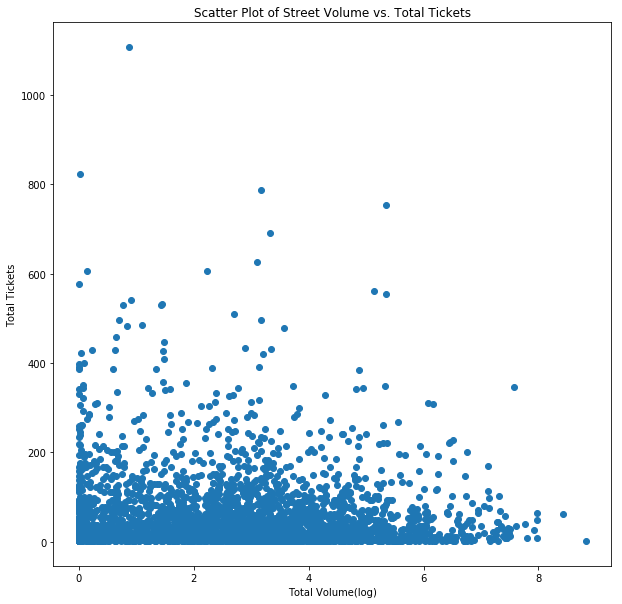

In [12]:
# Lets scatter volume against total tickets

plt.figure(figsize = (10, 10))
plt.scatter(x = np.log(streets['total_ea']), y = streets['total_tickets'])
plt.xlabel('Total Volume(log)')
plt.ylabel('Total Tickets')
plt.title('Scatter Plot of Street Volume vs. Total Tickets')

Text(0.5, 1.0, 'Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

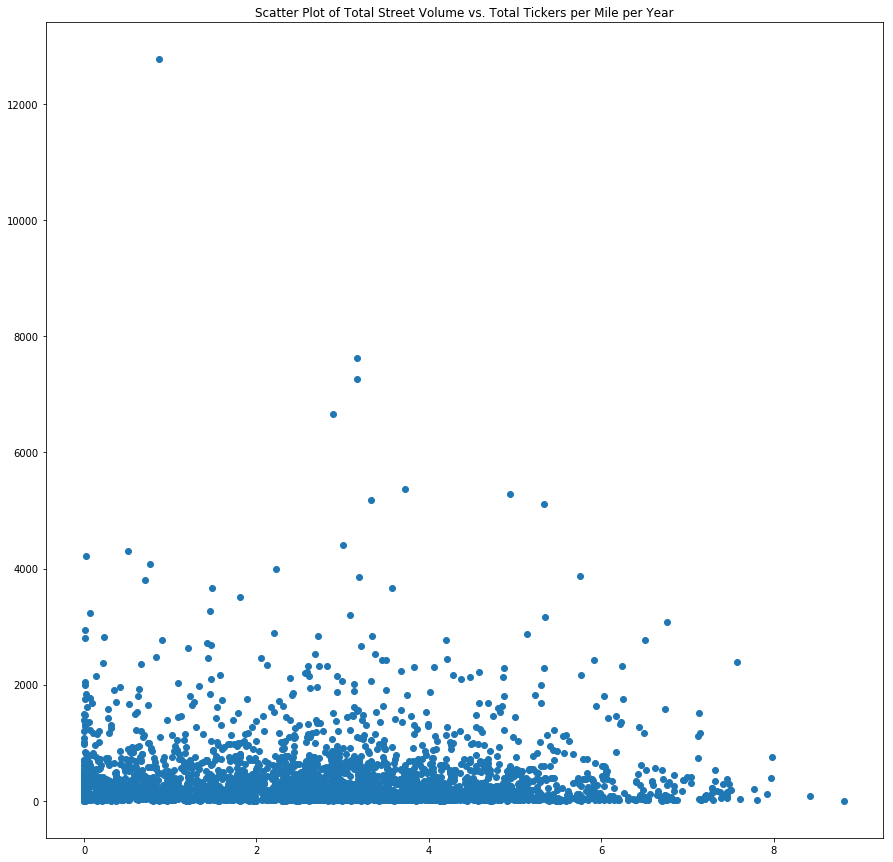

In [13]:
# Lets scatter street volume against volume over distance and convert to a per year basis ('Tickets per mile')
streets = streets[streets.distance > 0.01]
streets['tickpermile'] = streets['total_tickets'] / (streets['distance']) / totalyears
plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['tickpermile'])
plt.title('Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

Only the higher volume streets get any bus volume, and they all seem to be lower tickets per mile. 

In [14]:
streets.sort_values(by = 'tickpermile', ascending = False).head()

,lineid,nhood,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
792,40367.0,Mission,0.04,2.39663,1.36161,0.0,0.03502,13.88889,1108,12766.006699
1507,44408.0,Hayes Valley,0.03,23.61153,20.71085,0.0,1.90068,13.88889,496,7619.662242
1603,44745.0,Hayes Valley,0.05,23.73399,22.31019,0.0,0.42380,13.88889,788,7263.258685
1512,44434.0,Hayes Valley,0.03,17.91807,16.29234,0.0,0.62573,13.88889,434,6667.204461
1608,44759.0,Haight Ashbury,0.03,41.19893,39.40003,0.0,0.79890,13.88889,349,5361.415569


Text(0.5, 1.0, 'Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

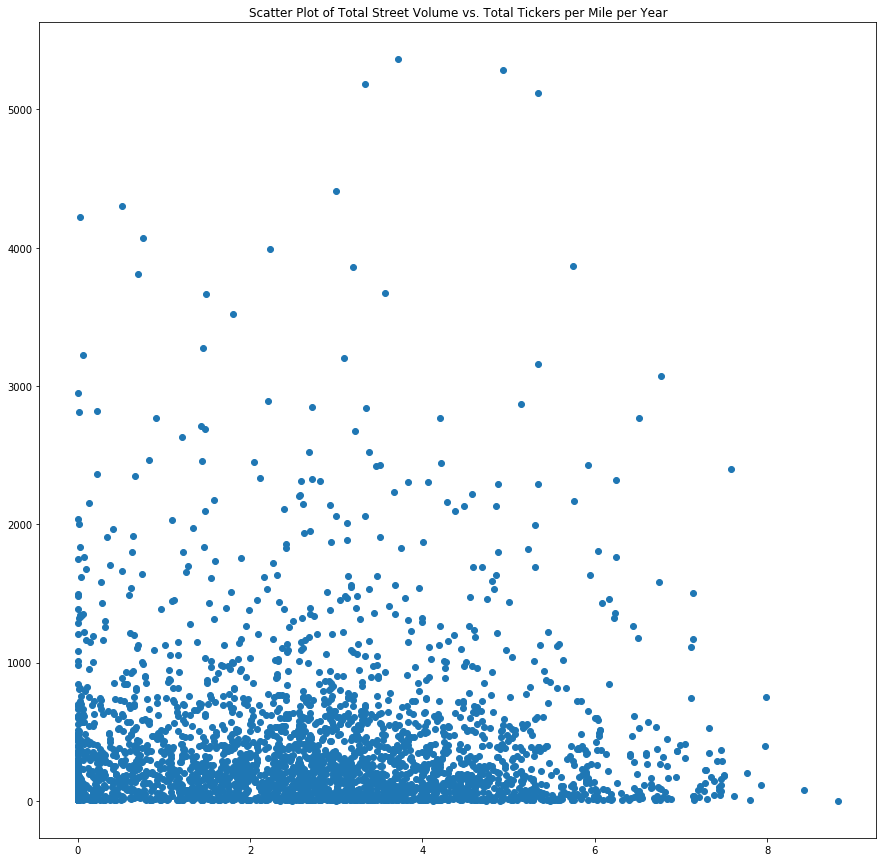

In [15]:
streets = streets[streets.tickpermile < 6000]
streets['tickpermile'] = streets['total_tickets'] / (streets['distance']) / totalyears
plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['tickpermile'])
plt.title('Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

In [16]:
streets.describe()

,lineid,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
count,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000
mean,43449.135088,0.078308,87.999615,79.038211,3.731396,4.230009,15.718042,60.305161,397.437389
std,5613.305024,0.044571,280.552053,265.526877,7.848374,15.564185,2.625847,80.978318,555.000756
min,28122.000000,0.014200,1.000010,0.000000,0.000000,0.000000,8.866510,1.000000,0.960139
25%,39727.500000,0.055285,4.185730,2.010780,0.000000,0.047095,13.888890,10.000000,73.738667
50%,44172.000000,0.070000,15.175950,10.085740,0.000000,0.355320,16.666660,33.000000,220.191852
75%,47253.000000,0.090000,55.506750,43.548035,0.000000,1.823705,16.666670,78.000000,486.470372
max,57758.000000,0.690000,6780.863410,6344.826690,90.000000,413.856720,54.999940,824.000000,5361.415569


In [17]:
streets = streets[streets.distance > .001]
streets.sort_values(by = 'tickpermile', ascending = False)

,lineid,nhood,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
1608,44759.0,Haight Ashbury,0.03000,41.19893,39.40003,0.00,0.79890,13.88889,349,5361.415569
1495,44345.0,Hayes Valley,0.03000,139.50367,130.60858,0.00,7.89509,13.88861,344,5284.604458
2458,48376.0,Inner Sunset,0.02000,28.08395,2.77902,24.00,0.30493,16.66667,225,5184.750013
1115,42870.0,North Beach,0.05000,207.96450,179.04455,21.18,6.73995,16.66546,555,5115.620013
717,39668.0,Mission,0.03000,20.06820,18.62831,0.00,0.43989,13.88889,287,4408.957789
709,39619.0,Mission,0.03000,1.67347,0.66071,0.00,0.01276,13.88889,280,4301.422233
812,40533.0,Hayes Valley,0.09000,1.02151,0.01166,0.00,0.00985,13.88889,824,4219.490381
2460,48383.0,Inner Sunset,0.06000,2.14528,1.02679,0.00,0.11849,16.66667,530,4070.988899
1611,44778.0,Haight Ashbury,0.07000,9.30786,8.25034,0.00,0.05752,13.88889,606,3989.788582
1372,43728.0,Mission,0.01561,314.05893,300.93984,0.00,12.11909,16.64272,131,3867.619057


In [18]:
#Lets split into two populations based on their street volume
df_lowvol = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 50)]
df_highvol = streets[streets.total_ea > np.percentile(streets['total_ea'], 50)]


In [19]:
df_lowvol.describe()

,lineid,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000
mean,43271.159280,0.080199,5.540941,3.791627,0.567770,0.181544,15.168131,68.098338,413.691320
std,5729.241201,0.035805,4.345477,3.889904,2.213624,0.342315,1.700446,88.752242,538.014116
min,29028.000000,0.020000,1.000010,0.000000,0.000000,0.000000,11.111110,1.000000,2.048296
25%,39264.500000,0.060000,1.685447,0.453130,0.000000,0.008477,13.888890,13.000000,92.173334
50%,43554.500000,0.070000,4.185730,2.428815,0.000000,0.055715,16.666670,38.000000,241.068719
75%,47395.000000,0.097225,9.002625,5.960250,0.000000,0.205015,16.666670,88.000000,508.000759
max,57758.000000,0.450000,15.175950,13.913550,12.860000,4.493040,19.444440,824.000000,4301.422233


In [20]:
df_highvol.describe()

,lineid,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,43627.234234,0.076416,170.515434,154.336941,6.897214,8.281279,16.268335,52.506584,381.172194
std,5491.052751,0.051825,379.324049,360.205438,9.915851,21.257221,3.209413,71.553965,571.217716
min,28122.000000,0.014200,15.210820,0.000000,0.000000,0.000000,8.866510,1.000000,0.960139
25%,40140.000000,0.050000,26.779780,20.027345,0.000000,0.591045,13.888890,8.500000,59.254286
50%,44496.000000,0.069600,55.506750,43.625650,0.000000,1.766990,16.666660,29.000000,195.868334
75%,47165.500000,0.090000,136.255895,123.866300,15.000000,6.654740,16.666670,68.000000,466.972166
max,57757.000000,0.690000,6780.863410,6344.826690,90.000000,413.856720,54.999940,754.000000,5361.415569


Text(0, 0.5, 'Tickets per Mile (log)')

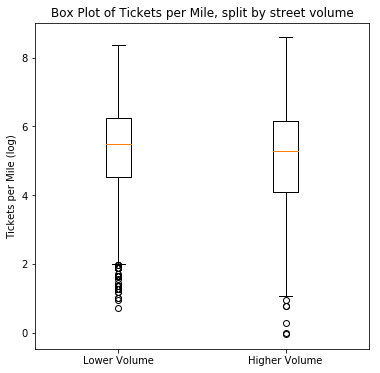

In [21]:
plt.figure(figsize = (6,6))
tickets = [np.log(df_lowvol['tickpermile']),  np.log(df_highvol['tickpermile'])]
plt.boxplot(tickets)
plt.title('Box Plot of Tickets per Mile, split by street volume')
plt.xticks(np.arange(1,3),['Lower Volume', 'Higher Volume'])
plt.ylabel('Tickets per Mile (log)')

Difference looks pretty insignificant, lets run a t-test. 

In [22]:
print(stats.ttest_ind(df_lowvol['tickpermile'], df_highvol['tickpermile'], equal_var = False))

Ttest_indResult(statistic=1.5744936753939134, pvalue=0.1154834107196533)


We can not reject the null hypothesis that they have the the same mean. 

In [23]:
df_lowvol['tickpermile'].mean() / df_highvol['tickpermile'].mean()

1.0853134785325131

Looks opposite my original hypotheses. Streets with lower volume tend to get less tickets per limear mile. 

In this case, it may be wise to use the central limit theorem, because you will not have the availablility of streets at your fingertips when finding a parking spot. Let's assume you can pick from 20 different blockss 

In [24]:
#since we have such a high variation, lets use the central limit theorem to estimate the means 
#of four categories of street volume
#Lets use a 3 way split and look at the means
df_1 = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 25)]
df_2 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 50)) & (streets.total_ea >  np.percentile(streets['total_ea'], 25))]
df_3 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 75)) & (streets.total_ea >  np.percentile(streets['total_ea'], 50))]
df_4 = streets[streets.total_ea > np.percentile(streets['total_ea'], 75)]

np.random.seed(1)
sample_1 = []
sample_2= []
sample_3 = []
sample_4 = []
for i in np.arange(1,1000):
    sample_1.append(df_1['tickpermile'].sample(n = 20).median())
    sample_2.append(df_2['tickpermile'].sample(n = 20).median())
    sample_3.append(df_3['tickpermile'].sample(n = 20).median())
    sample_4.append(df_4['tickpermile'].sample(n = 20).median())


In [25]:
sample_1 = np.array(sample_1)
sample_2 = np.array(sample_2)
sample_3 = np.array(sample_3)
sample_4 = np.array(sample_4)
total_samples = [sample_1, sample_2, sample_3, sample_4]

normals = {}

x = {}

for i in np.arange(0,4):
    df = total_samples[i]
    mean = df.mean()
    std = df.std()
    normals[i] = norm(loc = mean, scale = std)
    
    x[i] = np.linspace(normals[i].ppf(0.01), 
                        normals[i].ppf(0.99), 
                        100)

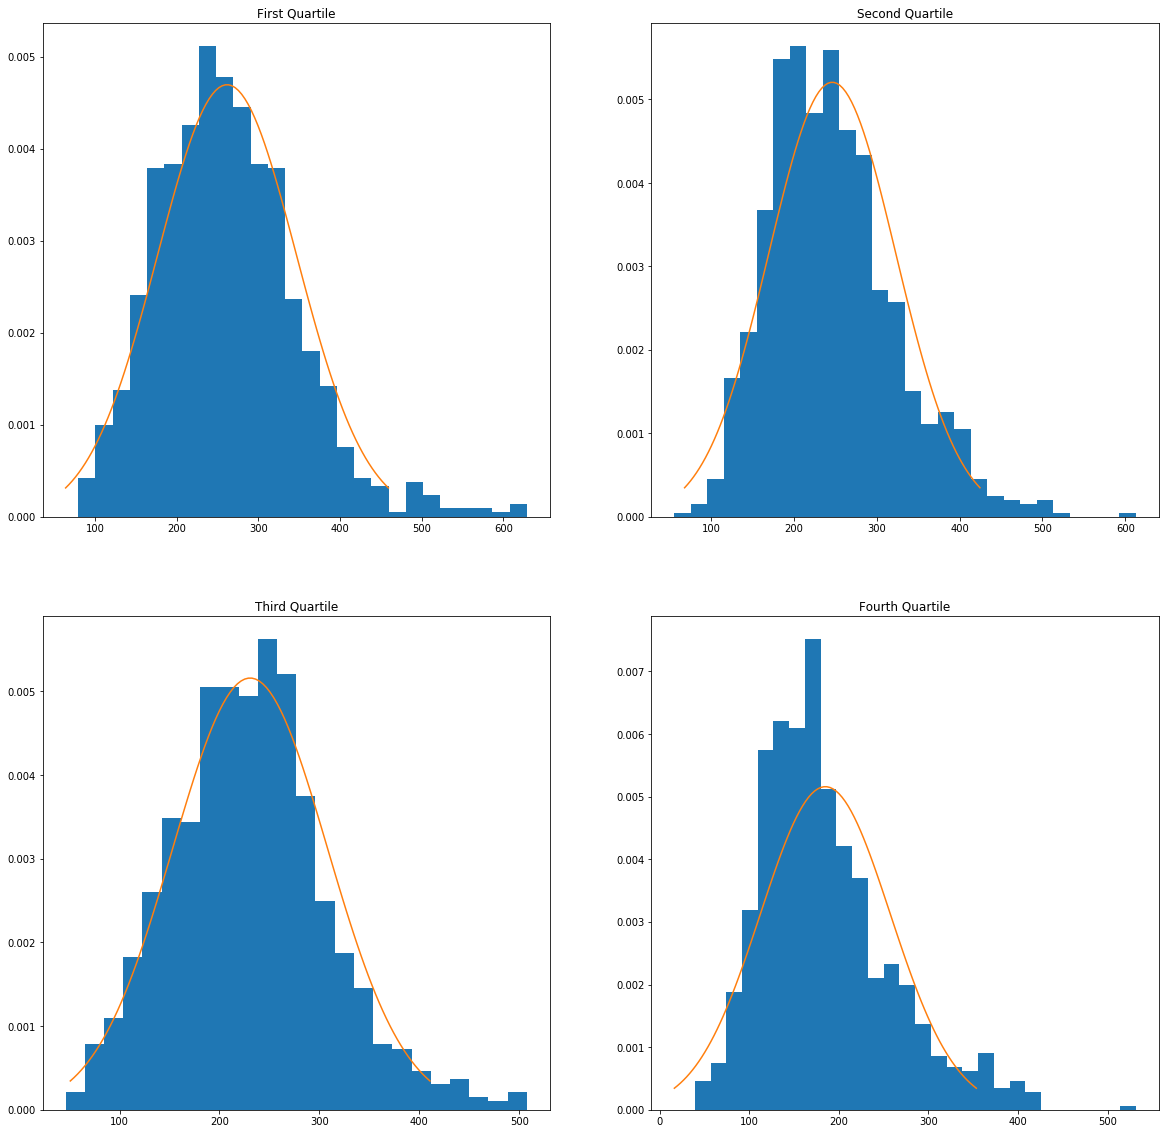

In [26]:
f, axarr = plt.subplots(2,2, figsize = (20,20))

axarr[0,0].hist(sample_1, density = True, bins = 'auto')
axarr[0, 0].plot(x[0], normals[0].pdf(x[0]))
axarr[0,0].set_title('First Quartile')

axarr[0,1].hist(sample_2, density = True, bins = 'auto')
axarr[0,1].plot(x[1], normals[1].pdf(x[1]))
axarr[0,1].set_title('Second Quartile')

axarr[1,0].hist(sample_3, density = True, bins = 'auto')
axarr[1,0].plot(x[2], normals[2].pdf(x[2]))
axarr[1,0].set_title('Third Quartile')

axarr[1,1].hist(sample_4, density = True, bins = 'auto')
axarr[1,1].plot(x[3], normals[2].pdf(x[2]))
axarr[1,1].set_title('Fourth Quartile')

plt.show()

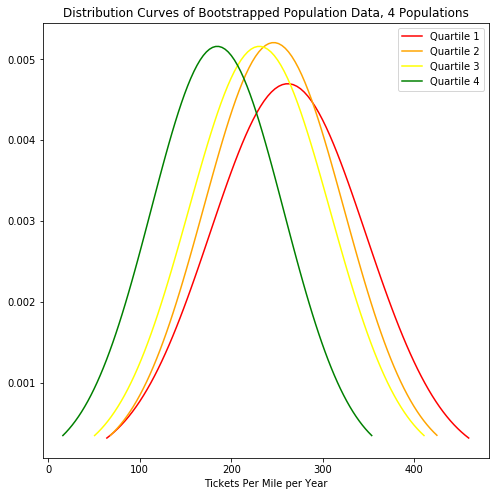

In [27]:
plt.figure(figsize = (8, 8))
plt.plot(x[0], normals[0].pdf(x[0]), color = 'red', label = 'Quartile 1')
plt.plot(x[1], normals[1].pdf(x[1]), color = 'orange', label = 'Quartile 2')
plt.plot(x[2], normals[2].pdf(x[2]), color = 'yellow', label = 'Quartile 3')
plt.plot(x[3], normals[2].pdf(x[2]), color = 'green', label = 'Quartile 4')
plt.title('Distribution Curves of Bootstrapped Population Data, 4 Populations', loc = 'center')
plt.xlabel('Tickets Per Mile per Year')
plt.legend( loc = 0)
plt.show()

The higest volume streets seems to be proving the point. 

Text(0.5, 0, 'Tickets per mile per year')

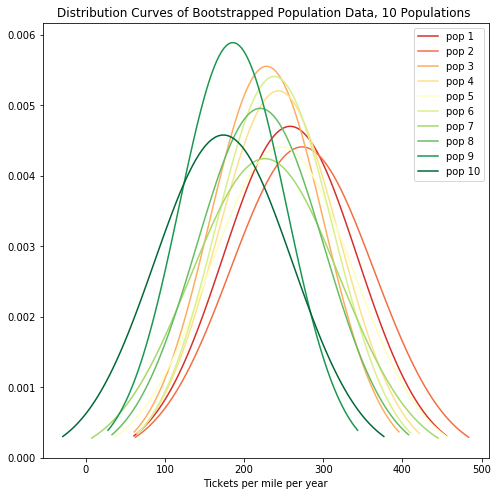

In [28]:
#Let's try to get a little more granular
plt.figure(figsize = (8, 8))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.total_ea <=  np.percentile(streets['total_ea'], i*10)]
    else:
        df = streets[(streets.total_ea <=  np.percentile(streets['total_ea'], i*10)) & (streets.total_ea >  np.percentile(streets['total_ea'], (i-1)*10))]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20, replace = True).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop ' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution Curves of Bootstrapped Population Data, 10 Populations ')
plt.xlabel('Tickets per mile per year')

Now we are seeing that the top 10% may have less than in the middle, so its only the highest volume streets that may have an effect. 

In [29]:
#since so many have the same value, we should probably filter the group on a sorted index so the sample sizes are all the same 
streets.sort_values(by = 'total_ea', inplace = True)


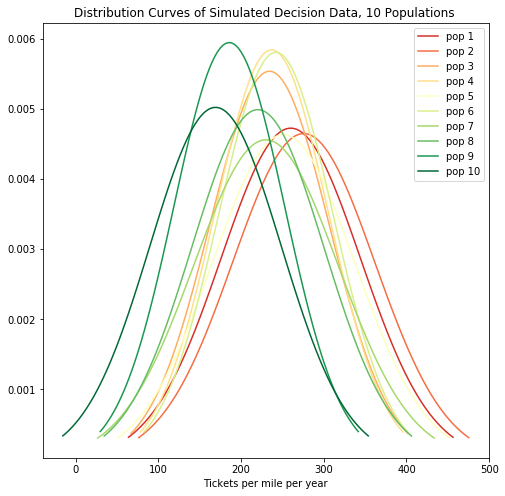

In [30]:
plt.figure(figsize = (8, 8))
means = {}
stds = {}
totalsize = streets.shape[0]
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]

    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop ' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution Curves of Simulated Decision Data, 10 Populations ')
plt.xlabel('Tickets per mile per year')
plt.savefig(image_folder + 'model/10PopVolSorted.png')

Were seeing the highest of volume actually may have a correlation with less tickets. 

In [31]:
means[10] / means[1]

0.650258835694199

Text(0.5, 0, 'Tickets per mile per year')

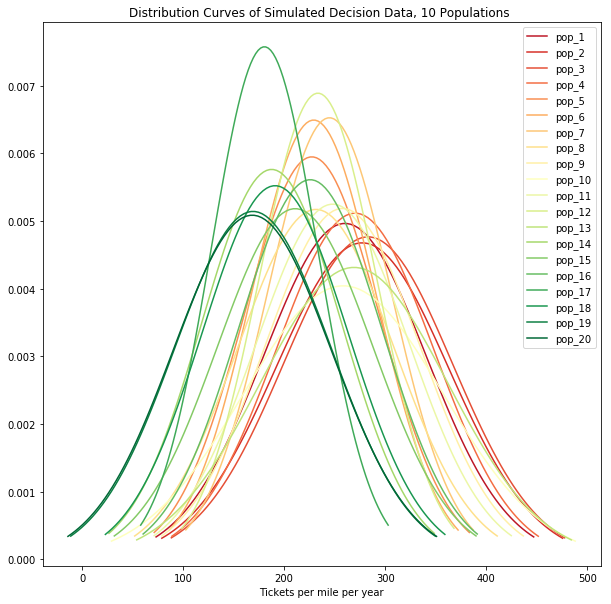

In [32]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}

for i in np.arange(1,21):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/20 * totalsize).astype(int): (((i)/20) * totalsize).astype(int)]
              
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop_' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/20))
plt.legend( loc = 0)
plt.title('Distribution Curves of Simulated Decision Data, 10 Populations ')
plt.xlabel('Tickets per mile per year')

Interesting. Our lower populations also can have less tickets per street. 
This would make sense as well since most if not all of these fall in the 'zero volume' category and are less likely streets for enforecement to travel down. Also note the standard deviation get's smaller with these categories, indicating it is more consistent. We noteice it's the outer bounds which will result in less tickets per mile, and the middle of the pack which stays more average. 

# Conclusion
Busier strets are less likely to get you a residential overtime ticket. Multiple factors could be ignored here. Some of these streets prohibit all parking on one or both sides during heavy transit hours in or out of downtown (ex. Bush 7AM - 9AM, while Pine 4PM - 6PM). This did not include how many parking spots were actually avilable on that street, and made the assumption all streets have the same number of spot ber linear mile. However, there exist many combinations of parking on one or both sides, and areas that are restricted. 

# Feature Analysis

Let's break the volume out and see which categories have bigger effects, we'll also include speed. 

In [33]:
df_lowtix = streets[streets.total_tickets <=  np.percentile(streets['tickpermile'], 50)]
df_hightix = streets[streets.total_tickets > np.percentile(streets['tickpermile'], 50)]

In [34]:
df_lowtix.describe()

,lineid,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
count,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000
mean,43427.235828,0.077563,89.475805,80.336242,3.815174,4.324389,15.725933,46.785974,319.961096
std,5617.276312,0.044454,284.032207,268.732401,7.921324,15.855427,2.551047,48.167755,378.623493
min,28122.000000,0.014200,1.000010,0.000000,0.000000,0.000000,8.866510,1.000000,0.960139
25%,39735.000000,0.050000,4.360798,2.124740,0.000000,0.049503,13.888890,10.000000,69.130000
50%,44168.000000,0.070000,15.656745,10.505290,0.000000,0.360875,16.666670,31.000000,199.708889
75%,47255.250000,0.090000,56.846082,44.565620,0.000000,1.869510,16.666670,69.000000,430.285795
max,57758.000000,0.690000,6780.863410,6344.826690,90.000000,413.856720,54.771730,220.000000,3867.619057


In [35]:
df_hightix.describe()

,lineid,distance,total_ea,vvol_carea,vvol_busea,vvol_trkea,speed_ea,total_tickets,tickpermile
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,43895.555556,0.093501,57.907211,52.577608,2.023556,2.306048,15.557181,335.896296,1976.805972
std,5533.360645,0.044407,194.940758,187.434390,5.946150,7.230249,3.856043,115.446329,1026.976163
min,31077.000000,0.020000,1.000210,0.000000,0.000000,0.000000,11.111110,223.000000,277.765586
25%,39697.500000,0.060000,1.887070,0.687145,0.000000,0.015945,13.888890,251.000000,1308.232882
50%,44338.000000,0.090000,8.335930,5.042420,0.000000,0.156960,13.888890,300.000000,1766.655560
75%,46533.500000,0.110000,25.257470,21.286585,0.000000,1.172530,16.666670,386.000000,2342.493380
max,57747.000000,0.370000,1956.619720,1885.475070,27.000000,70.144650,54.999940,824.000000,5361.415569


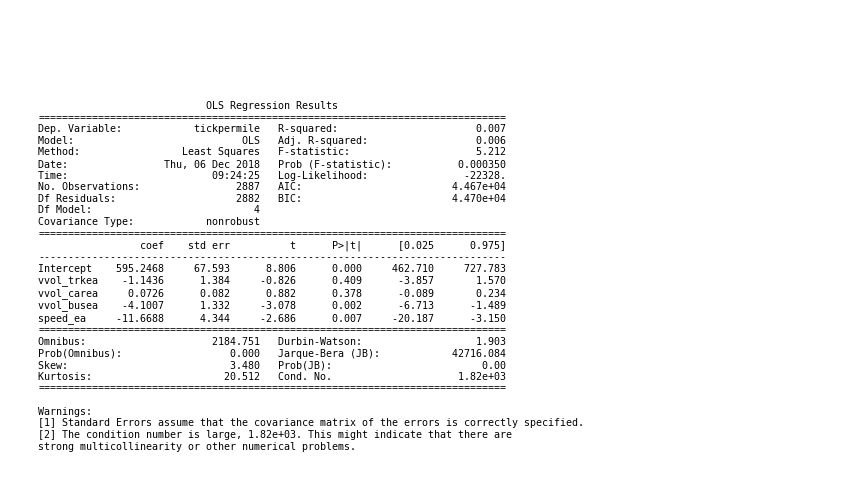

In [36]:
import statsmodels.api as sm
columns = ['vvol_trkea', 'vvol_carea', 'vvol_busea', 'speed_ea']

model = sm.OLS.from_formula('tickpermile ~' + '+'.join(columns) , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()


The R squared volume is extremely low, showing there is clearly a lot this model is missing. However, the coefficients look to be somewhat strong. Looks as though bus volume and speed seem to have more of an effect than trucks or cars. Let's use the fitted values to set our index, and re-do our central limit theorem exercise and see if the population differences are measurable. 

In [37]:
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)

Text(0.5, 0, 'Tickets per mile per year')

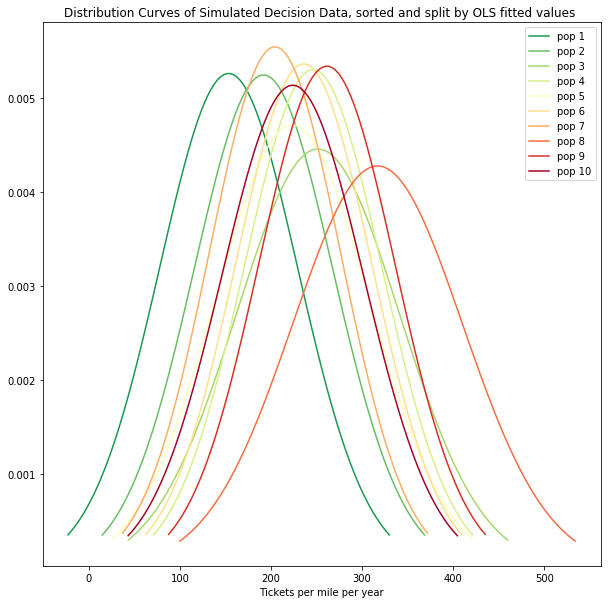

In [38]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop ' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Distribution Curves of Simulated Decision Data, sorted and split by OLS fitted values ')
plt.xlabel('Tickets per mile per year')

In [39]:
means[1] / means[10]

0.6855444967627686

This model would suggest the difference between the top and lowest population groups could reduce the amount of tickets by up to 50%. 

The Higher our variables get, the fit seems to be stronger, which would confirm that using these measure may be an accurate way to estimate ticket probability. Let's check out some diagnostic plots to confirm this. 

In [40]:
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag


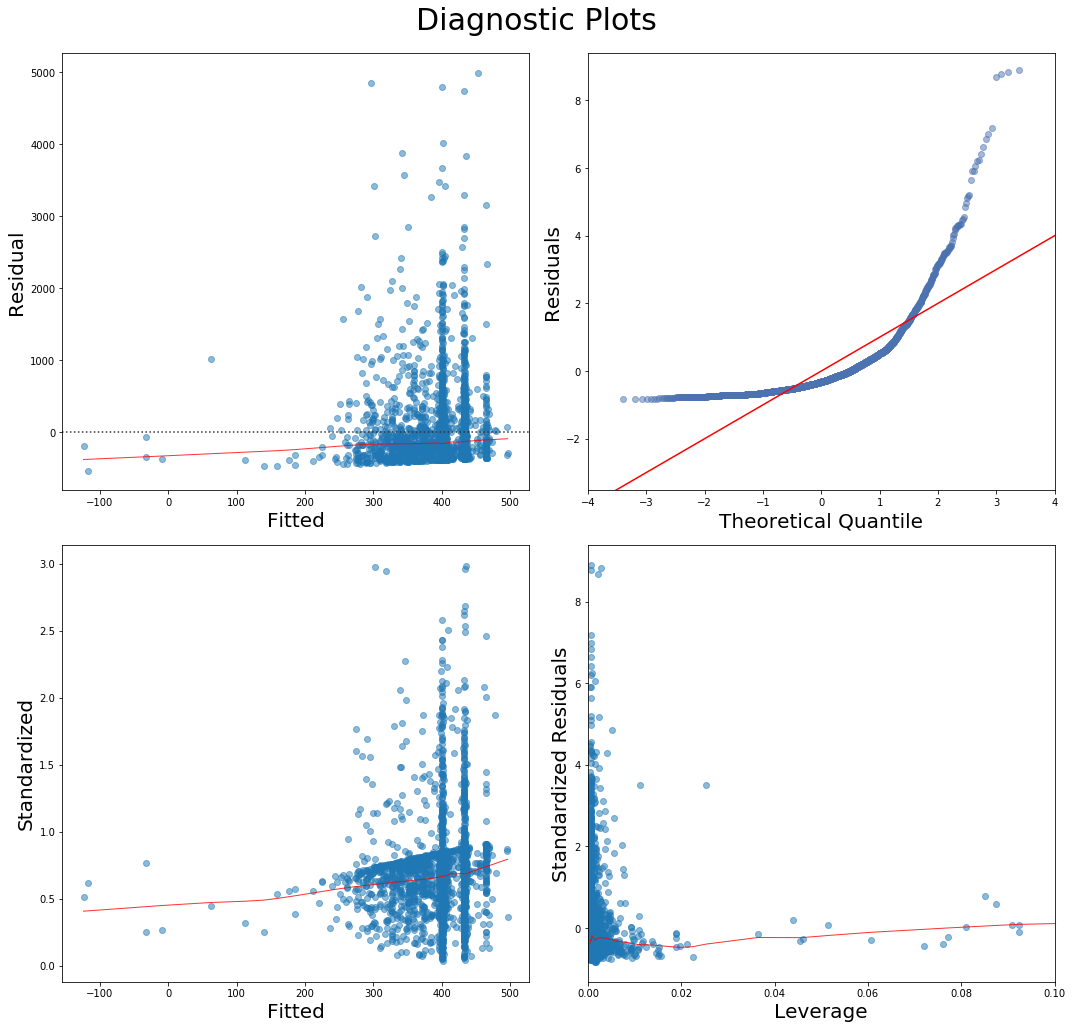

In [41]:
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (15,15))
fig.suptitle('Diagnostic Plots for OLS Model')
QQ = ProbPlot(model_norm_residuals)
plt.suptitle('Diagnostic Plots',  fontsize = 30)

#residuals 
sns.residplot( model_fitted_y, 'tickpermile', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted', fontsize = 20)
axarr[0,0].set_ylabel('Residual', fontsize = 20)


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile', fontsize = 20)
axarr[0,1].set_ylabel('Residuals', fontsize = 20)
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted', fontsize = 20)
axarr[1,0].set_ylabel('Standardized', fontsize = 20)


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage', fontsize = 20)
axarr[1,1].set_ylabel('Standardized Residuals', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

The Q-Q Plot indicates there may be a non-linear relationship here. Let's try a few other fits. 

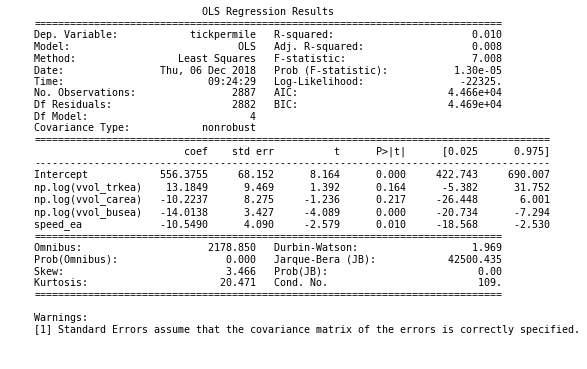

In [42]:
df = streets
for column in columns:
    df[column] = df[column] + 0.01
    
formstring = 'tickpermile ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+speed_ea'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
res.summary()
plt.rc('figure', figsize=(8, 5))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig(image_folder + 'model/basemodelsum.png')
plt.show()

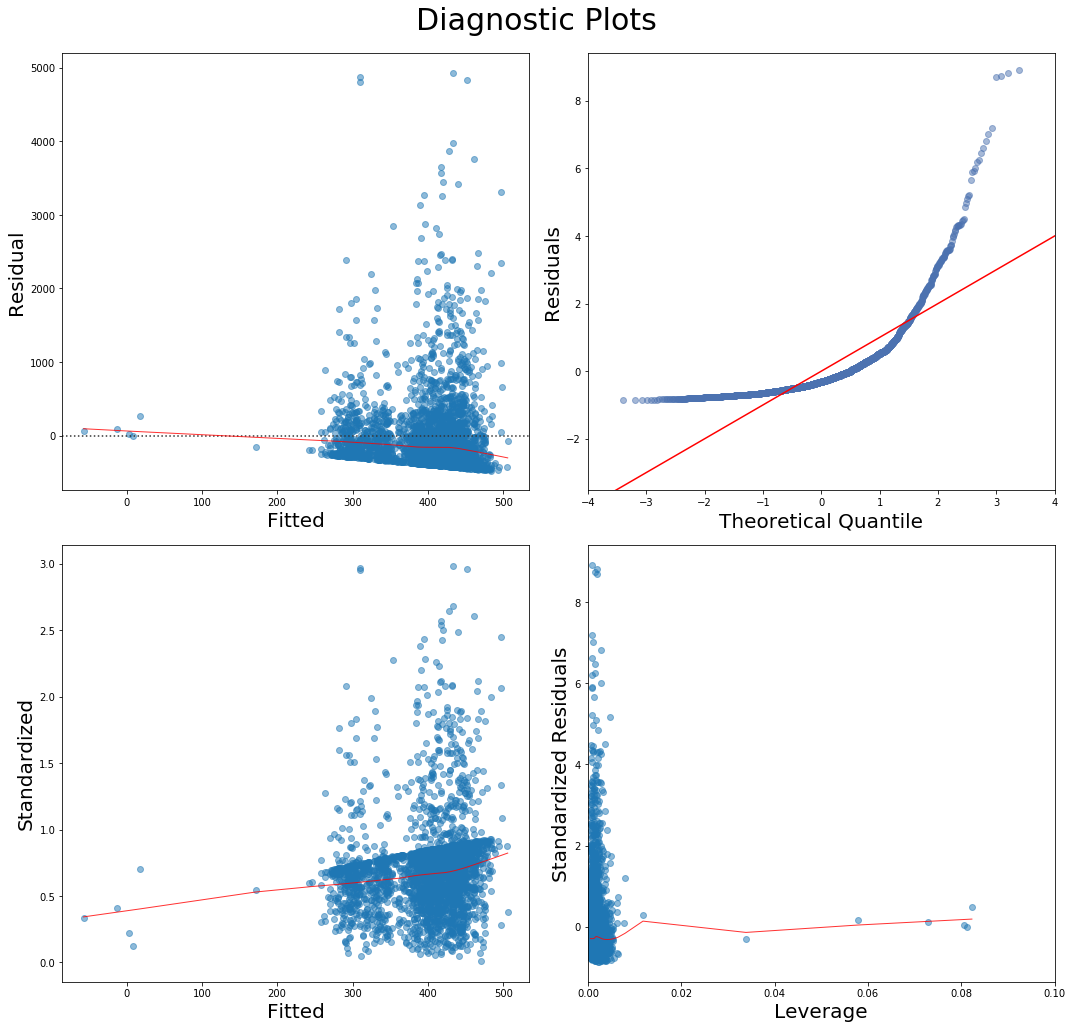

In [43]:
# Log fit seems to be a little better. 
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (15,15))
fig.suptitle('Diagnostic Plots for OLS Model')
QQ = ProbPlot(model_norm_residuals)
plt.suptitle('Diagnostic Plots',  fontsize = 30)

#residuals 
sns.residplot( model_fitted_y, 'tickpermile', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted', fontsize = 20)
axarr[0,0].set_ylabel('Residual', fontsize = 20)


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile', fontsize = 20)
axarr[0,1].set_ylabel('Residuals', fontsize = 20)
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted', fontsize = 20)
axarr[1,0].set_ylabel('Standardized', fontsize = 20)


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage', fontsize = 20)
axarr[1,1].set_ylabel('Standardized Residuals', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

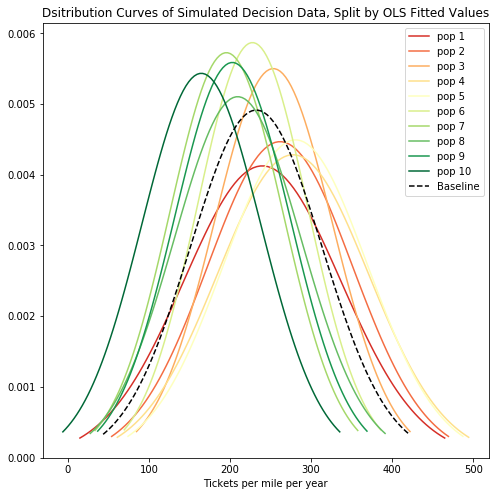

In [44]:
#Re-do our central limit exercise once again. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', ascending = False,  inplace = True)
plt.figure(figsize = (8, 8))
means = {}
stds = {}
df = streets
sample = []
boxdata = []

for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]

    sample = []
    boxdata.append(df['tickpermile'])
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop ' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn((i/10)))

sample = []

df = streets
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickpermile'].sample(n = 20).median())
 
sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), 
                    normals.ppf(0.99), 
                    100)
labelstr = str(i * 10) + '%'

plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')    

    
plt.legend( loc = 0)
plt.title('Dsitribution Curves of Simulated Decision Data, Split by OLS Fitted Values')
plt.xlabel('Tickets per mile per year')
plt.savefig(image_folder + 'model/noparkingOLS.png')

''

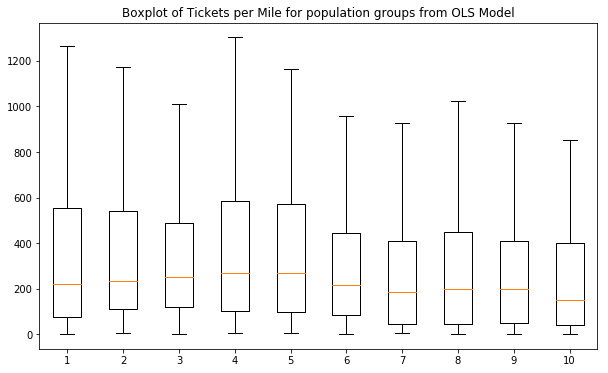

In [45]:
plt.figure(figsize = (10,6))
plt.boxplot(boxdata, showfliers = False)
plt.title('Boxplot of Tickets per Mile for population groups from OLS Model')
;


In [46]:
means[10] / means['base']

0.708467740181894

In [47]:
means[10] / means[1]

0.6863508858172878

# Conclusion




Interestingly, the most important feature is actually bus volume. This however, points out an initial flaw in that bus stops take up parking spots. For that reason, I decided to run the analysis again with parking included. 